# ImgLib2 

Example 04: Specialized iterables

Example 4 will focus on how to work with specialized **iterables**. They are especially useful when performing operations in the local neighborhood of many pixels - like finding local minima/maxima, texture analysis, convolution with non-separable, non-linear filters and many more. One elegant solution is to write a specialized [**Iterable**](https://docs.oracle.com/javase/8/docs/api/java/lang/Iterable.html) that will iterate all pixels in the local neighborhood. We implemented two examples:

* A [**HyperSphere**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/region/hypersphere/HyperSphere.html) that will iterate an n-dimensional sphere with a given radius at a defined location..
* A [**LocalNeighborhood**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/neighborhood/Neighborhood.html) that will iterate n-dimensionally all pixels adjacent to a certain location, but skip the central pixel (this corresponds to neighbors in 1d, an 8-neighborhood in 2d, a 26-neighborhood in 3d, and so on ...)

In [1]:
// @ImageJ ij
// @NotebookService nb

// Behind a firewall? Configure your proxy settings here.
//systemProperties = System.getProperties()
//systemProperties.setProperty("http.proxyHost","myproxy.domain")
//systemProperties.setProperty("http.proxyPort","8080")

//////////////////////////////////////////////////////////////
// Load ImageJ. This may take some minutes the first time   //
// while ImageJ is installed into ~/.groovy/grapes locally. //
//////////////////////////////////////////////////////////////
/*@GrabResolver(name='imagej', root='http://maven.imagej.net/content/groups/public/')
@Grab('net.imagej:imagej:2.0.0-rc-58')
import net.imagej.ImageJ
ij = new ImageJ()*/
println("ImageJ is ready to go.")

ImageJ is ready to go.


null

## Example 4a - Drawing a sphere full of spheres

In the first sample we simply draw a sphere full of little spheres. We therefore create a large [**HyperSphere**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/region/hypersphere/HyperSphere.html) in the center of a [**RandomAccessibleInterval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessibleInterval.html). Note that the **HyperSphere** only needs a [**RandomAccessible**](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html), we need the additional [**Interval**](http://javadoc.imagej.net/ImgLib2/net/imglib2/util/Intervals.html) simply to compute the center and the radius of the large sphere. When iterating over all pixels of this large sphere, we create a small [**HyperSphere**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/region/hypersphere/HyperSphere.html) at every n'th pixel and fill them with a random intensity.

This example illustrates the use of specialized **Iterables**, and emphasizes the fact that they can be stacked on the underlying [**RandomAccessible**](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html) using the location of one as the center of a new one. Note that we always create new instances of [**HyperSphere**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/region/hypersphere/HyperSphere.html) . The code reads very nicely but might not offer the best performance. We therefore added *update* methods to the [**HyperSphere**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/region/hypersphere/HyperSphere.html)  and its **Cursor** that could be used instead.

Another interesting aspect of this example is the use of the [**ImagePlusImgFactory**](http://javadoc.imagej.net/ImgLib2/net/imglib2/img/imageplus/ImagePlusImgFactory.html), which is the compatibility container for ImageJ. If the required dimensionality and [**Type**](http://javadoc.imagej.net/ImgLib2/net/imglib2/type/Type.html) is available in ImageJ, it will internally create an ImagePlus and work on it directly. In this case, one can request the ImagePlus and show it directly. It will, however, fail if [**Type**](http://javadoc.imagej.net/ImgLib2/net/imglib2/type/Type.html) and dimensionality are not supported by ImageJ and throw a [**ImgLibException**](http://javadoc.imagej.net/ImgLib2/net/imglib2/exception/ImgLibException.html).

In [2]:
import java.util.Random
import net.imglib2.Point
import net.imglib2.RandomAccessibleInterval
import net.imglib2.algorithm.region.hypersphere.HyperSphere
import net.imglib2.algorithm.region.hypersphere.HyperSphereCursor
import net.imglib2.exception.ImgLibException
import net.imglib2.type.numeric.RealType
import net.imglib2.util.Util
 
/**
 * Example 4a - Drawing a sphere full of spheres
 *
 * @author Stephan Preibisch & Stephan Saalfeld
 *
 */
construct01 = new Object() {
  
  /**
    * Draws a sphere that contains lots of small spheres into the center of the
    * interval.
    *
    * @param <T> value type
    * @param randomAccessible - the image data to write to
    * @param minValue - the minimal intensity of one of the small spheres
    * @param maxValue - the maximal intensity of one of the small spheres
   */
  public <T extends RealType<T>> void drawSpheres(final RandomAccessibleInterval<T> randomAccessible, final double
    minValue, final double maxValue)
  {
    // the number of dimensions
    int numDimensions = randomAccessible.numDimensions()
    
    // define the center and radius
    Point center = new Point(randomAccessible.numDimensions())
    int minSize = randomAccessible.dimension(0)
    
    for (int d = 0; d < numDimensions; ++d) {
      int size = randomAccessible.dimension(d)
      int half = size / 2
      center.setPosition(half, d)
      minSize = Math.min(minSize, size)
    }
    
    // define the maximal radius of the small spheres
    final int maxRadius = 5
    
    // compute the radius of the large sphere so that we do not draw
    // outside of the defined interval
    final long radiusLargeSphere = minSize / 2 - maxRadius - 1
    
    // instantiate a random number generator
    final Random rnd = new Random(System.currentTimeMillis())
    
    // define a hypersphere (n-dimensional sphere)
    HyperSphere<T> hyperSphere = new HyperSphere<T>(randomAccessible, center, radiusLargeSphere)
    
    // create a cursor on the hypersphere
    HyperSphereCursor<T> cursor = hyperSphere.cursor()

    while (cursor.hasNext()) {
      cursor.fwd()
      
      // the random radius of the current small hypersphere
      final int radius = rnd.nextInt(maxRadius) + 1
      
      // instantiate a small hypersphere at the location of the current pixel in the large hypersphere
      HyperSphere<T> smallSphere = new HyperSphere<T>(randomAccessible, cursor, radius)
      
      // define the random intensity for this small sphere
      final double randomValue = rnd.nextDouble()
      
      // take only every 4^dimension'th pixel by chance so that it is not too crowded
      if (Math.round(randomValue * 100) % Util.pow(4, numDimensions) == 0) {
        // scale to right range
        randomValue = rnd.nextDouble() * (maxValue - minValue) + minValue
        
        // set the value to all pixels in the small sphere if the intensity is brighter than the existing one
        for (final T value : smallSphere) {
          value.setReal(Math.max(randomValue, value.getRealDouble()))
        }
      }
    }
  }
}

Script2$1@20fb96ed

**Note:** The current display method can only display the first frame of multi-framed images, so we only see a "black" image.

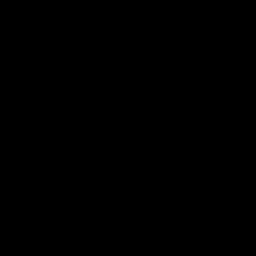

In [3]:
import net.imglib2.type.numeric.integer.UnsignedByteType
import net.imglib2.img.Img;
import net.imglib2.img.ImgFactory;
import net.imglib2.img.array.ArrayImgFactory;

long[] dims = [256, 256, 256]
ImgFactory<UnsignedByteType> imgFactory = new ArrayImgFactory<UnsignedByteType>();
Img<UnsignedByteType> img = imgFactory.create(dims, new UnsignedByteType());

// draw a small sphere for every pixel of a larger sphere
int minv = 0
int maxv = 255
construct01.drawSpheres(img, minv, maxv)

// show the hyperspheres
nb.display(img)

## Example 4b - Finding and displaying local minima

In this example we want to find all local minima in an image and display them as small spheres. To not capture too much of the noise in the image data, we first perform an in-place Gaussian smoothing with a sigma of 1, i.e. the data will be overwritten with the result. A complete documentation of the gauss package for ImgLib2 can be found  [here](http://imagej.net/Gauss_Package_ImgLib2).

We display the results using a binary image. *Note that the [**BitType**](http://javadoc.imagej.net/ImgLib2/net/imglib2/type/logic/BitType.html) only requires one bit per pixel and therefore is very memory efficient.*

The generic method for minima detection has some more interesting properties. The type of the source image data actually does not require to be of [**Type**](http://javadoc.imagej.net/ImgLib2/net/imglib2/type/Type.html), it simply needs something that is comparable. The [**LocalNeighborhood**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/neighborhood/Neighborhood.html) will iterate n-dimensionally all pixels adjacent to a certain location, but skip the central pixel (this corresponds to neighbors in 1d, an 8-neighborhood in 2d, a 26-neighborhood in 3d, and so on ...). This allows to efficiently detect if a pixel is a local minima or maxima. Note that the [**Cursor**](http://javadoc.imagej.net/ImgLib2/net/imglib2/Cursor.html) that performs the iteration can have special implementations for specific dimensionalities to speed up the iteration. See below the example for a specialized three-dimensional iteration:

Please note as well that if one would increase the radius of the [**RectangleShape**](http://javadoc.imagej.net/ImgLib2/net/imglib2/algorithm/neighborhood/RectangleShape.html) to more than 1 (without at the same time changing the [**View**](http://javadoc.imagej.net/ImgLib2/net/imglib2/View.html) on source that creates an inset border of exactly this one pixel), this example would fail as we would try to write image data outside of the defined boundary. [**OutOfBoundsStrategies**](http://javadoc.imagej.net/ImgLib2/net/imglib2/view/Views.html) which define how to handle such cases is discussed in example 5.

In [4]:
import net.imglib2.Cursor
import net.imglib2.Interval
import net.imglib2.RandomAccessibleInterval
import net.imglib2.algorithm.gauss.Gauss
import net.imglib2.algorithm.neighborhood.Neighborhood
import net.imglib2.algorithm.neighborhood.RectangleShape
import net.imglib2.algorithm.region.hypersphere.HyperSphere
import net.imglib2.img.Img
import net.imglib2.img.ImgFactory
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.type.NativeType
import net.imglib2.type.logic.BitType
import net.imglib2.type.numeric.RealType
import net.imglib2.util.Intervals
import net.imglib2.view.Views
 
construct02 = new Object() {
  /**
    * Checks all pixels in the image if they are a local minima and draws a circle into the output if they are
    *
    * @param <T> value type
    * @param <U>
    * @param source - the image data to work on
    * @param imageFactory - the factory for the output img
    * @param outputType - the output type
    * @return - an Img with circles on locations of a local minimum
  */
  public static <T extends Comparable<T>, U extends RealType<U>> Img<U> findAndDisplayLocalMinima(
      RandomAccessibleInterval<T> source, ImgFactory<U> imageFactory, U outputType) {
    // Create a new image for the output
    Img<U> output = imageFactory.create(source, outputType)
    
    // define an interval that is one pixel smaller on each side in each dimension,
    // so that the search in the 8-neighborhood (3x3x3...x3) never goes outside
    // of the defined interval
    Interval interval = Intervals.expand(source, -1)
    
    // create a view on the source with this interval
    source = Views.interval(source, interval)
    
    // create a Cursor that iterates over the source and checks in an 8-neighborhood if it is a minima
    final Cursor<T> center = Views.iterable(source).cursor()
    
    // instantiate a RectangleShape to access rectangular local neighborhoods
    // of radius 1 (that is 3x3x...x3 neighborhoods), skipping the center pixel
    // (this corresponds to an 8-neighborhood in 2d or 26-neighborhood in 3d, ...)
    final RectangleShape shape = new RectangleShape(1, true)
    
    // iterate over the set of neighborhoods in the image
    for (final Neighborhood<T> localNeighborhood : shape.neighborhoods(source)) {
      // what is the value that we investigate?
      // (the center cursor runs over the image in the same iteration order as neighborhood)
      final T centerValue = center.next()
      
      // keep this boolean true as long as no other value in the local neighborhood
      // is larger or equal
      boolean isMinimum = true
      
      // check if all pixels in the local neighborhood that are smaller
      for (final T value : localNeighborhood) {
        // test if the center is smaller than the current pixel value
        if (centerValue.compareTo(value) >= 0) {
          isMinimum = false
          break
        }
      }
      
      if (isMinimum) {
        // draw a sphere of radius one in the new image
        HyperSphere<U> hyperSphere = new HyperSphere<U>(output, center, 1)
        
        // set every value inside the sphere to 1
        for (U value : hyperSphere) {
          value.setOne()
        }
      }
    }
    
    return output
  }
}

Script4$1@101cec91

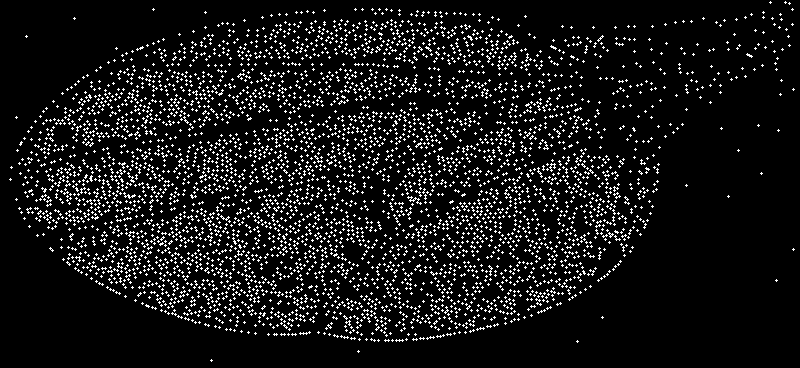

In [7]:
import io.scif.img.ImgOpener
import net.imglib2.img.Img
import net.imglib2.algorithm.gauss.Gauss
import net.imglib2.type.logic.BitType
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.type.numeric.real.FloatType

img = new ImgOpener().openImgs("http://samples.fiji.sc/tutorials/DrosophilaWing.tif").get(0)

// first we do a small in-place gaussian smoothing with a sigma of 1.0
double[] sigmas = [1.0, 1.0]
Gauss.inDoubleInPlace(sigmas, img)

// find local minima and paint them into another image as spheres
featureMap = construct02.findAndDisplayLocalMinima(img, new ArrayImgFactory<BitType>(), new BitType())

// show the hyperspheres
nb.display(featureMap)